In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Examine fits

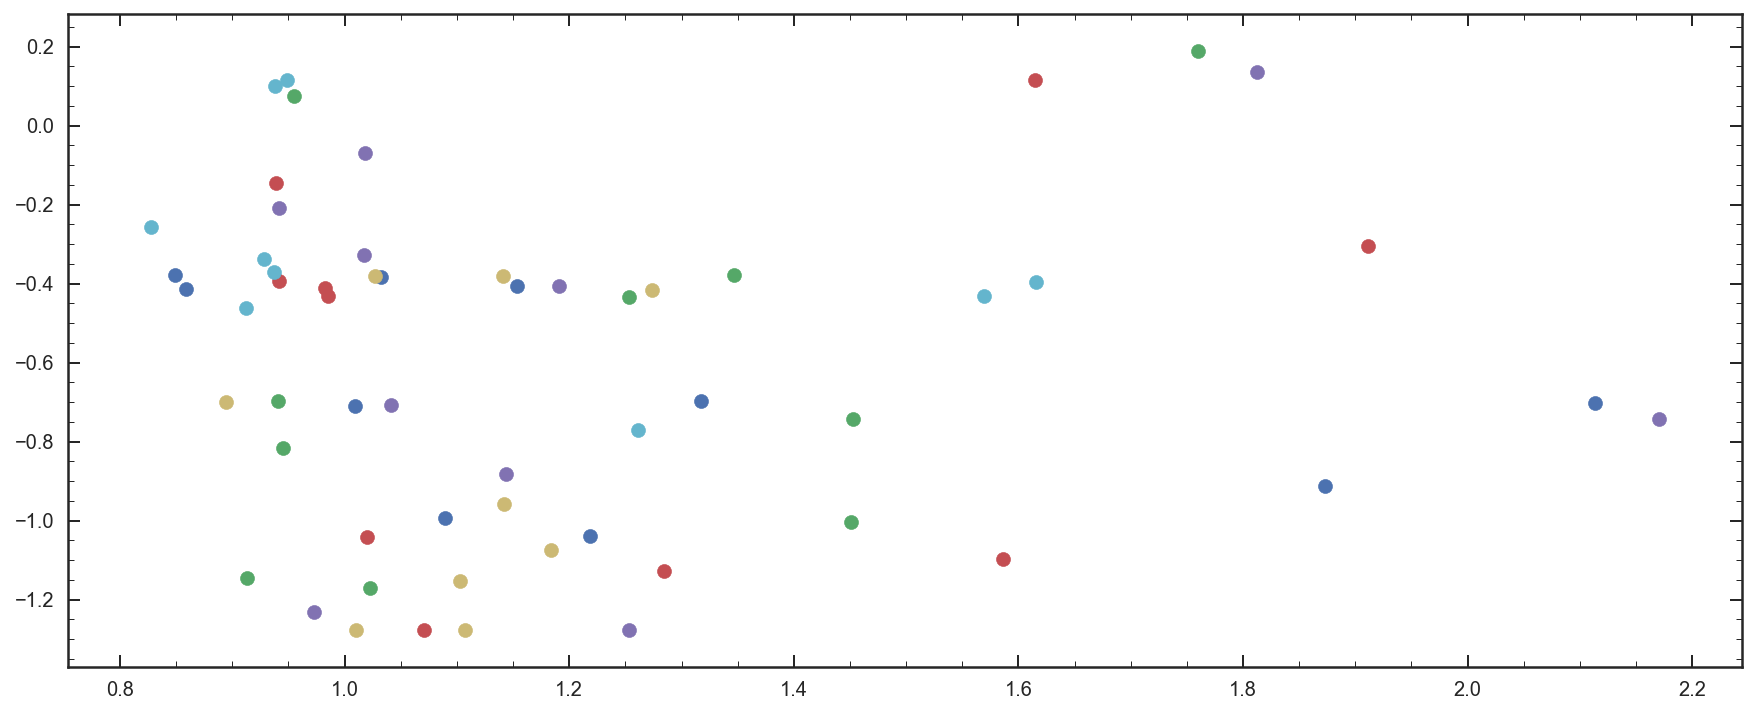

In [20]:
flist = glob('../data/posteriors/G*tabfit_Pm.*')
zlist = glob('../data/posteriors/G*tabfit_Pz.*')

plt.figure(figsize=[15,6])
for i in range(len(flist)):
    x,px = np.load(flist[i])
    z,pz = np.load(zlist[i])
    plt.scatter(z[pz == max(pz)],np.log10(x[px == max(px)]))
    
# plt.scatter([1,1.25,1.75],[3.1,2.5,2], color='k')
# plt.ylim(0,7)
# # plt.xlim(.1,2)

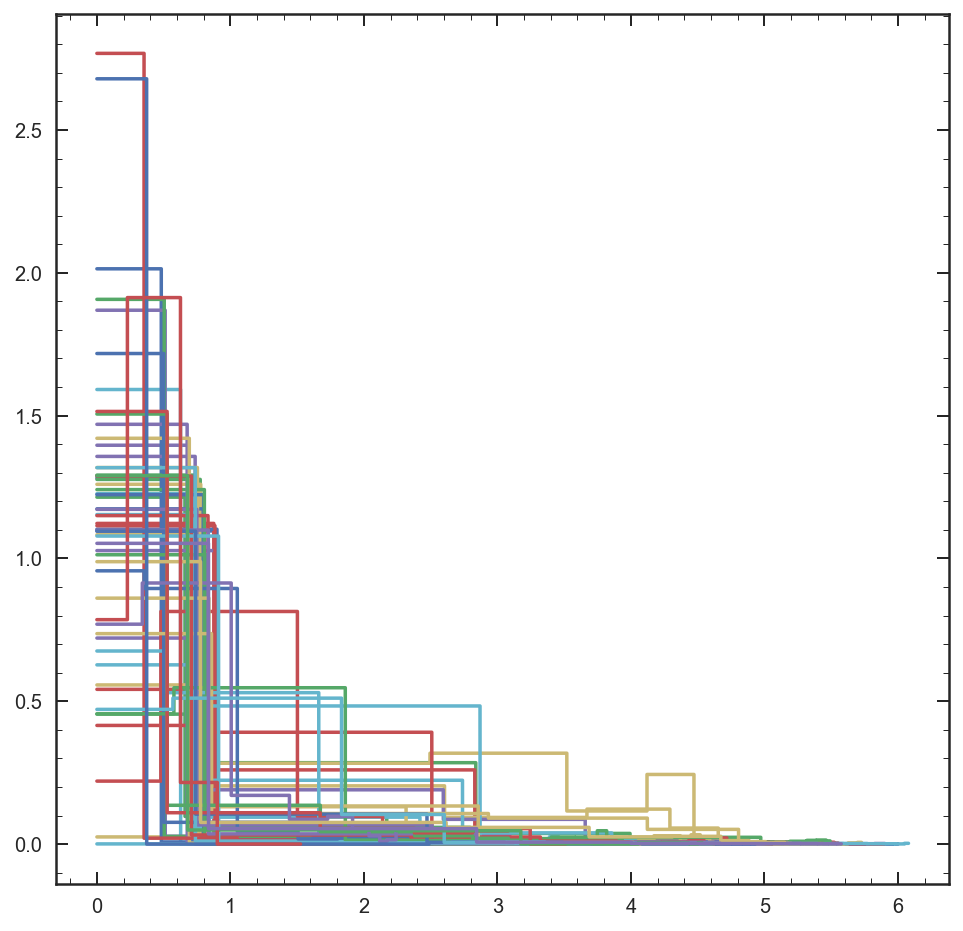

In [27]:
flist = glob('../data/bestfits/G*_tabfit_bfit.npy')

plt.figure(figsize = [8,8])

for i in flist:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(i)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    plt.plot(time,sfr)


In [19]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

def PLOT(field, galaxy, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    
    
    Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.05, irac_err = 0.1, decontam = True) 

    Gs.Sim_all_premade(wave*(1+z),flux)
    
    gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,10])
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / gcal[0],Gs.Ber*1E18 / gcal[0],
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  gcal[1],Gs.Rer*1E18 / gcal[1],
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,0])
    plt.plot(z,pz)
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(field, galaxy))

    plt.subplot(gs[1,1])
    plt.plot(z,pz)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,2])
    plt.plot(z,pz)
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
    
    plt.subplot(gs[1,3])
    plt.plot(z,pz)
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
        plt.savefig('../plots/ALMA/all_data_{0}.png'.format(galaxy),bbox_inches = 'tight')

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


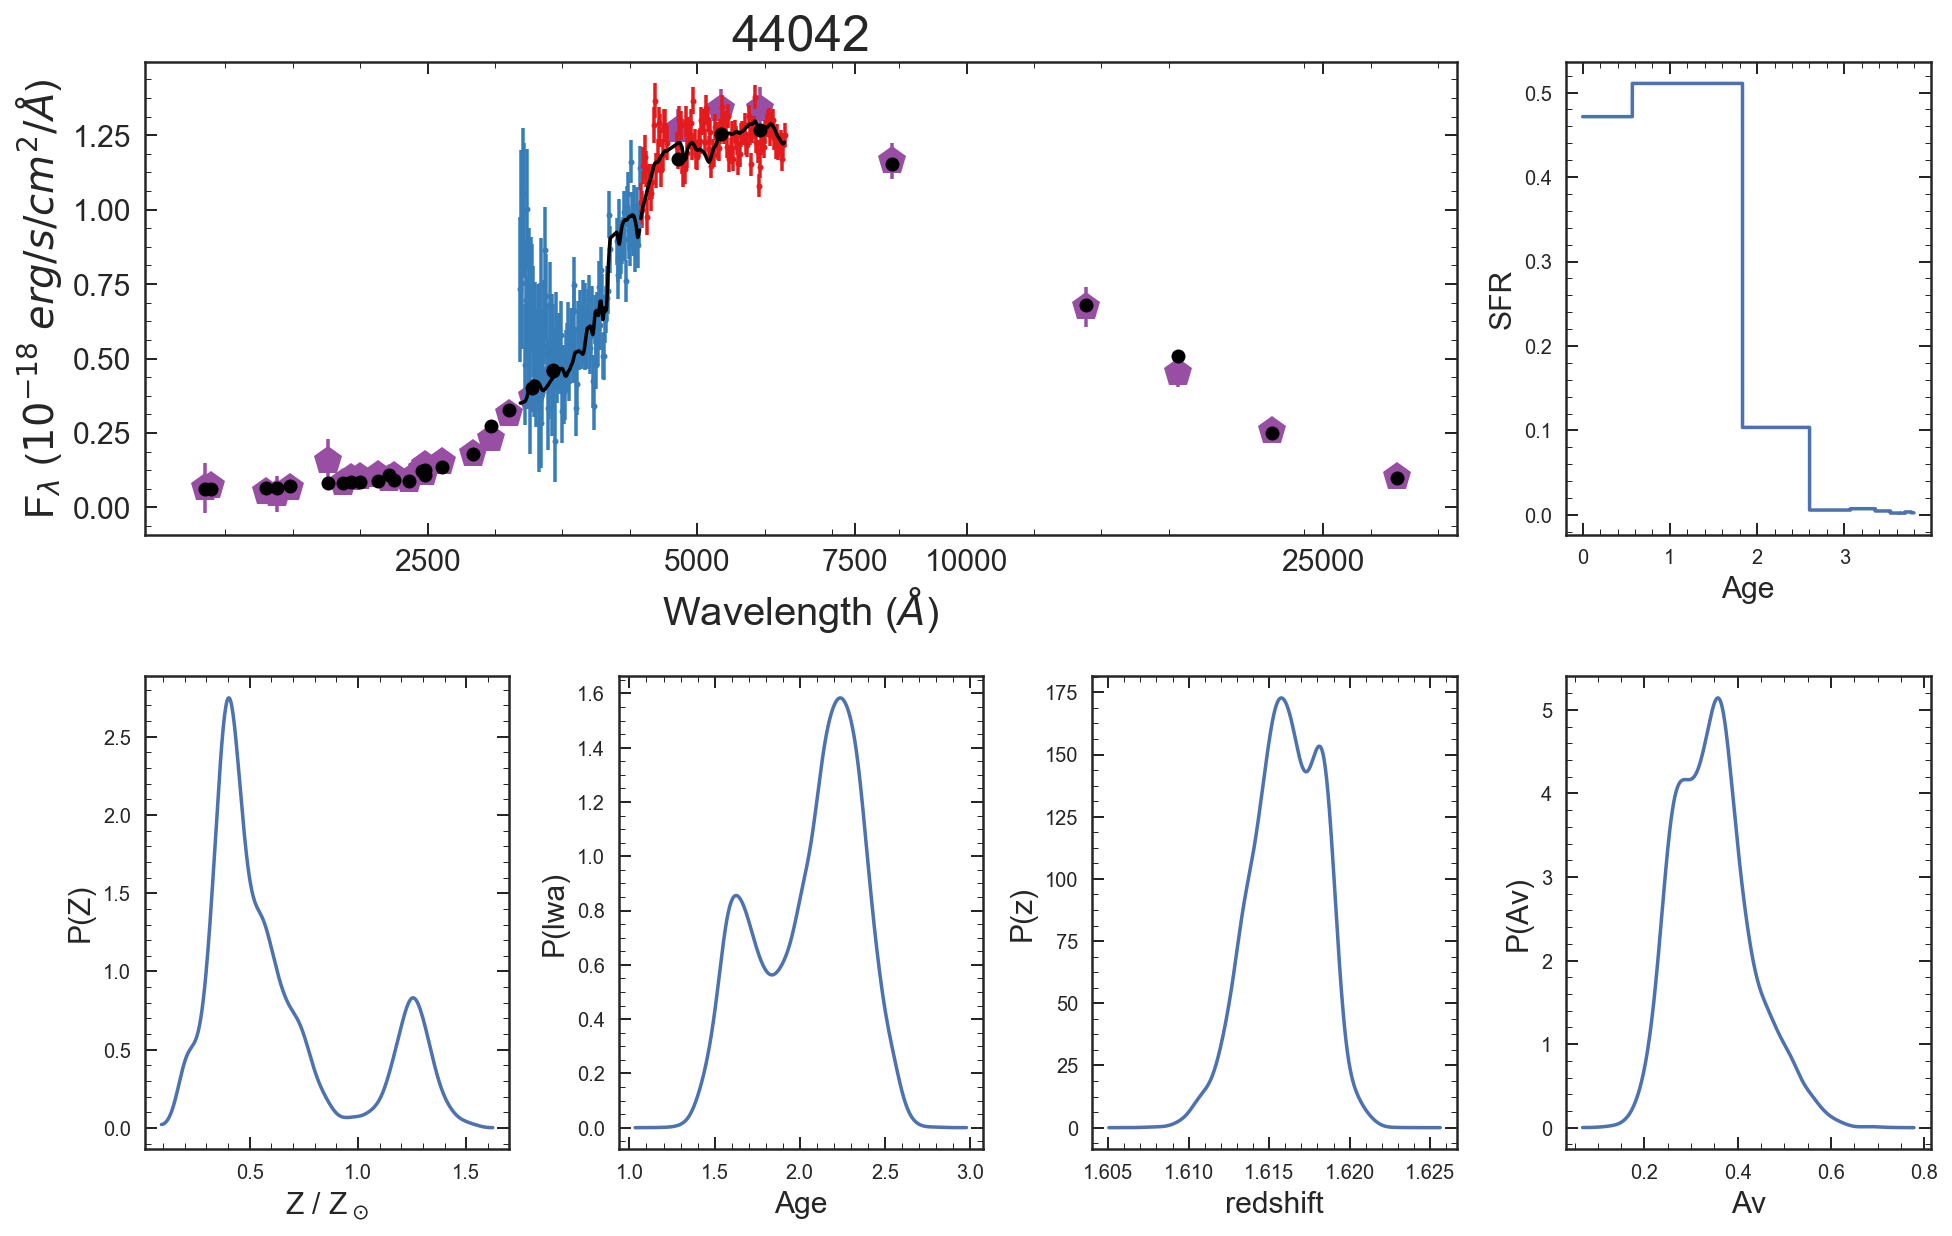

In [27]:
PLOT('GSD', 44042)